# Convolutional Neural Networks (CNN)
***

Treinar uma rede CNN para classificar imagens do dataset `CIFAR-10` utilizando `aumento de dados`

O dataset e composto de imagens coloridas divididas em `10 classes`

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Como essas imagens sao maiores `(32x32x3)`, pode ser muito util acelerar o processo de treinamento usando processamento em placa de video. 

`CUDA` e uma plataforma de computacao paralela que utiliza tensores (tipo os arrays do `numpy`) para computar informacoes na `GPU`.


- Checando se o CUDA esta disponivel

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

***
## Carregando o dataset

Carregar o dataset pode demorar. Por isso é possível carregar os dados de treinamento e teste, dividir o conjunto de treinamento em treinamento e validacao, e criar os `Dataloaders` para cada um desses conjuntos.

## Aumento de dados

Vamos tambem executar uma forma simples de `aumentar os dados` que inverte e rotaciona as imagens de forma aleatoria. 

Isso e feito definindo uma transformacao do `torchvision`. Fora essas, existem outas [transformações](https://pytorch.org/vision/stable/transforms.html) para pre-processamento e aumento de dados, do Pytorch.

Este tipo de aumento de dados deve adicionar alguma variedade em relacao a posicao das imagens, para que quando treinarmos o modelo e seja robusto em relacao a mudancas geometricas 
  - exemplo: reconhecer um navio, independente da direcao em que ele esteja apontando). E recomendavel que sempre sejam escolhidas uma ou duas transformacoes.

In [8]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [9]:
# numero de subprocessos usados para carregar os dados
num_workers = 0
# quantas amostras serao carregadas para cada batch
batch_size = 20
# porcentagem dos conjuntotes de treinamento e validacao
valid_size = 0.2

In [10]:
#  converte os dados para um torch.FloatTensor normalizado
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # inverte e rotaciona aleatoriamente
    transforms.RandomRotation(10),     # rotaciona aleatoriamente em 10 graus
    transforms.ToTensor(),             # transforma em tensor para ser consumido pelo modelo
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     # normalizacao de cada canal
    ])
 

In [11]:
# escolhe os dados de treino e teste
train_data = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=False,
                             download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/.pytorch/CIFAR10_data/cifar-10-python.tar.gz to /root/.pytorch/CIFAR10_data/
Files already downloaded and verified


In [12]:
# obtem os indices de treino que serao usados para validacao
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [13]:
num_train

50000

In [14]:
num_train * valid_size

10000.0

In [15]:
split

10000

In [16]:
np.floor(100.99)

100.0

In [17]:
# define os samplers para extrair os batches de treinamento e validacao
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /root/.pytorch/CIFAR10_data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [19]:
train_sampler

In [20]:
num_workers

0

In [21]:
# prepara os data loaders passando os batches e os samplers (combina o dataset e o sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualizando o batch de treinamento


In [22]:
# especifica a classe das imagens
classes = ['aviao', 'automovel', 'passaro', 'gato', 'veado',
           'cachorro', 'sapo', 'cavalo', 'navio', 'caminhao']

In [23]:
%matplotlib inline

# funcao auxiliar para desnormalizar e mostrar a imagem
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # converte o tensor para imagem

In [24]:
train_loader

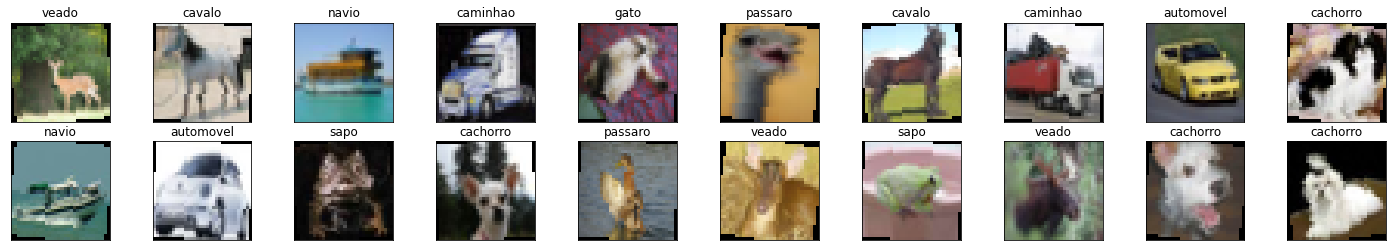

In [25]:
# obtem um batch de amostras de treinamento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # converte as imagens para formato numpy para apresentar

# plota as imagens no batch, junto com os respectivos rotulos
fig = plt.figure(figsize=(25, 4))

# mostra 20 imagens
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [26]:
images.shape

(20, 3, 32, 32)

### Visualizando as imagens com maiores detalhes
Aqui nos olhamos para os canais vermelho, verde e azul (RGB) normalizados como tres canais separados de intensidade em tons de cinza.



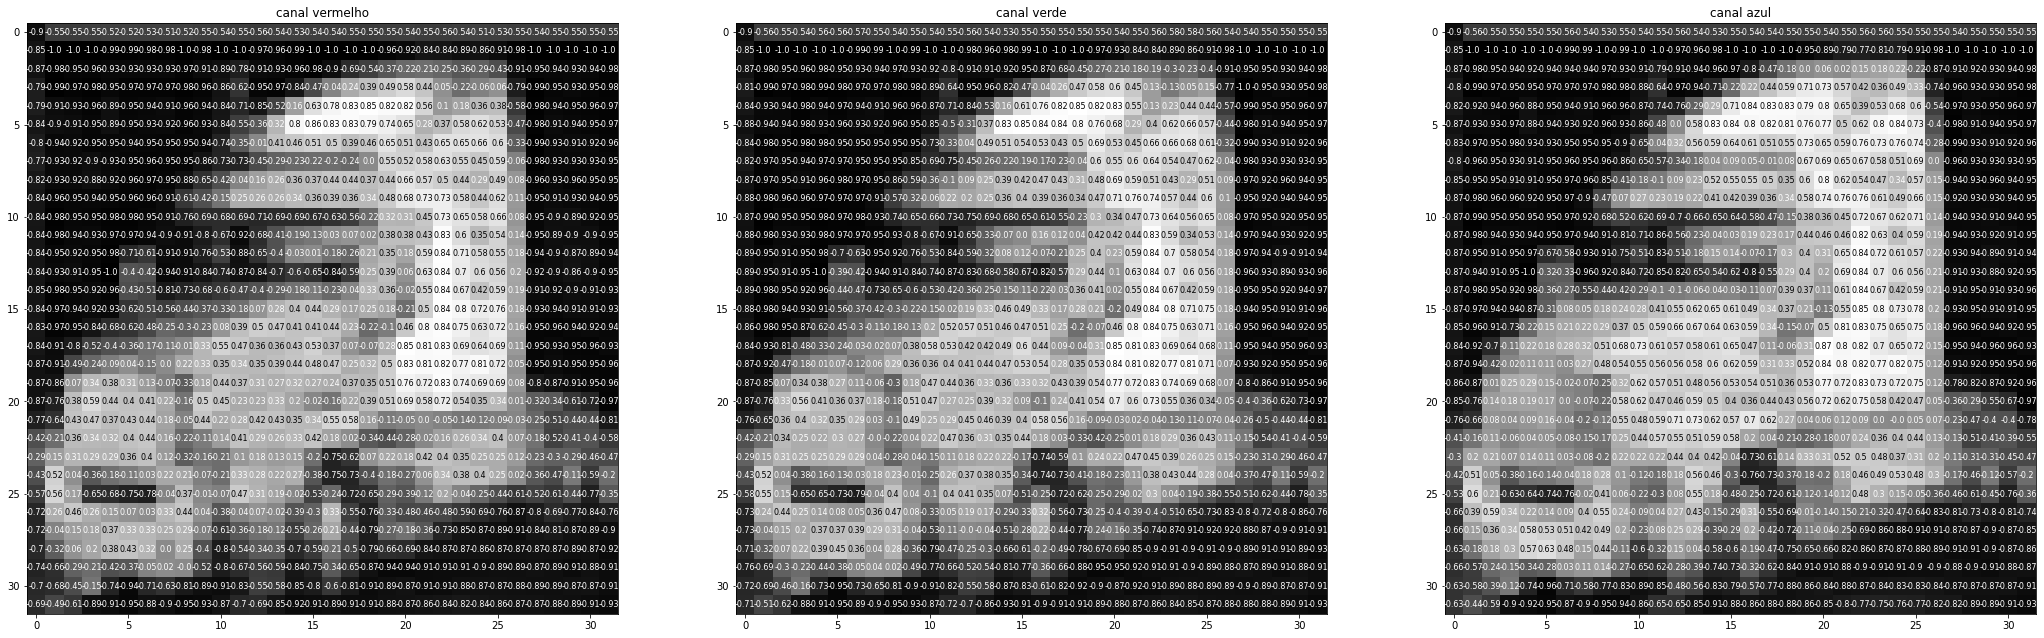

In [27]:
rgb_img = np.squeeze(images[3])
channels = ['canal vermelho', 'canal verde', 'canal azul']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Definindo a arquitetura da rede CNN
Ao invés de camadas lineares, como nas redes MLP, usamos as camadas:

1) convolucionais: 
- as quais podem ser consideradas um empilhamento de imagens filtradas.

2) Maxpooling: 
- as quais reduzem as dimensoes de uma entrada, mantendo apenas os pixels mais ativos da camada anterior

3) lineares  e 4) Dropout 

- para evitar overfitting e produzir uma saida de dimensionalidade igual a 10 (numero de classes).



# Definindo um modelo com multiplas camadas convolucionais
- e definindo o comportamento do modelo durante a passagem feedforward.
- Quanto mais camadas convolucionais forem incluidas, mais complexos são os padrões de `cor` e `forma` que o modelo é capaz de detectar. 
- Para o `Dataset CIFAR10`, é sugerido um modelo com 2 ou 3 camadas convolucionais, com camadas lineares e dropout para evitar overfitting. 
- Os valores dos hiperparâmetros devem otimizados, podendo buscar também na literature.

In [28]:
32 - 2 * np.floor(5/2)

28.0

In [29]:
import torch.nn as nn
import torch.nn.functional as F

# Definindo nossa arquitetura
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Camada convolucional (enxerga um tensor representando uma imagem de dimensao 32x32x3)
          # dimensao da imagem de entrada é: (m x m) = (32 x 32)
          # tamanho do kernel: (n x n) = (3x3)
          # cálculo dos canais de saída: (((W - K + 2P)/S) + 1)
                                          # W = Input size
                                          # K = Filter size
                                          # S = Stride
                                          # P = Padding        
        # primeiro parametro: é o numero de canais de entrada (3, RGB)
        # segundo parametro: é o numero de canais de saida 
        #################### pode ser calculado por: (((32 - 3 + 2)/1) + 1) = 

        # terceiro e o tamanho do kernel (filtro de 3x3) e o padding e uma moldura para evitar que a imagem seja redimensionada.
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # Camada convolucional (enxerga um tensor de  16x16x16 - 16 canais, dimensionalidade reduzida de 32x32 pela camada de MaxPool)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Camada convolucional (enxerga um tensor de  8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # camada max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        # camada linear (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # camada linear (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # camada dropout (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
      
        # adiciona uma sequencia de convolucoes e maxpooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # achata x, transformando em um vetor
        x = x.view(-1, 64 * 4 * 4)

        # adiciona a camada dropout
        x = self.dropout(x)

        # adiciona a primeira camada escondida, com ativacao relu
        x = F.relu(self.fc1(x))

        # adiciona uma camada dropout
        x = self.dropout(x)

        # adiciona segunda camada escondida, com ativacao relu
        x = self.fc2(x)
        return x

# cria uma CNN completa
model = Net()
print(model)

# move os tensores pra GPU, se o CUDA estiver disponivel
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## Definindo a funcao de custo
- Loss: a melhor funcao de custo e otimizacao para a tarefa de classificacao deve ser escolhida.

- LR: Taxa de aprendizado, determina como o modelo vai convergir para um erro menor.

In [30]:
import torch.optim as optim

# especificamos como funcao de custo a funcao categorical cross-entropy
criterion = nn.CrossEntropyLoss()

# e como funcao de otimizacao o gradiente descendente estocastico
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Treinando a rede
- Verificar como o custo de treinamento e a validacao diminuem conforme o tempo. 
- Se o `custo de validacao` aumenta, pode indicar `overfitting`.

In [32]:
# numero de epocas de treinamento
n_epochs = 30

valid_loss_min = np.Inf # mantem registro do custo minimo de validacao

for epoch in range(1, n_epochs+1):

    # mantem registro dos custos de treinamento e validacao
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # treina o modelo #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move os tensores pra GPU se o CUDA estiver disponivel
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # limpa os gradientes de todas as variaveis otimizadas
        optimizer.zero_grad()
        # passo forward: computa as saidas do modelo
        output = model(data)
        # calcula o custo por batch
        loss = criterion(output, target)
        # passo backward: computa o gradiente do custo em respeito aos parametros do modelo
        loss.backward()
        # executa um unico passo de otimizacao (atualizacao dos parametros)
        optimizer.step()
        # atualiza o custo de trein
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # valida o modelo #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move os tensores para a GPU se o CUDA estiver disponivel
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # passo forward: computa as saidas do modelo
        output = model(data)
        # calcula o custo por batch
        loss = criterion(output, target)
        # atualiza o custo de validacao
        valid_loss += loss.item()*data.size(0)
    
    # calcula a media dos custos
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # imprime  as estatisticas de treino e validacao 
    print('Epoca: {} \tCusto de treinamento: {:.6f} \tCusto de validacao: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # salva o modelo se o custo de validacao diminuir
    if valid_loss <= valid_loss_min:
        print('Reducao do custo de validacao ({:.6f} --> {:.6f}).  Salvando o modelo ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoca: 1 	Custo de treinamento: 0.959068 	Custo de validacao: 0.915260
Reducao do custo de validacao (inf --> 0.915260).  Salvando o modelo ...
Epoca: 2 	Custo de treinamento: 0.938842 	Custo de validacao: 0.903889
Reducao do custo de validacao (0.915260 --> 0.903889).  Salvando o modelo ...
Epoca: 3 	Custo de treinamento: 0.907421 	Custo de validacao: 0.894780
Reducao do custo de validacao (0.903889 --> 0.894780).  Salvando o modelo ...
Epoca: 4 	Custo de treinamento: 0.889349 	Custo de validacao: 0.850801
Reducao do custo de validacao (0.894780 --> 0.850801).  Salvando o modelo ...
Epoca: 5 	Custo de treinamento: 0.865535 	Custo de validacao: 0.849071
Reducao do custo de validacao (0.850801 --> 0.849071).  Salvando o modelo ...
Epoca: 6 	Custo de treinamento: 0.842486 	Custo de validacao: 0.830083
Reducao do custo de validacao (0.849071 --> 0.830083).  Salvando o modelo ...
Epoca: 7 	Custo de treinamento: 0.826020 	Custo de validacao: 0.789405
Reducao do custo de validacao (0.830083 

***
Carregando o modelo com menor custo de validacao


In [33]:
model.load_state_dict(torch.load('model_augmented.pt'))


<All keys matched successfully>

## Testando a rede treinada
Testa seu modelo treinado em dados novos. 

Um "bom" resultado sera uma CNN com acuracia acima de 70% sobre as imagens de teste.

In [34]:
# registra o custo de teste
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# itera sobre os dados de teste
for batch_idx, (data, target) in enumerate(test_loader):
    # move os tensores pra GPU, se disponivel
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # passo forward: computa as saidas do modelo
    output = model(data)
    # computa o custo do batch
    loss = criterion(output, target)
    # atualiza o custo de teste
    test_loss += loss.item()*data.size(0)
    # converte as probabilidades para a classe predita
    _, pred = torch.max(output, 1)    
    # compara as predicoes com os rotulos reais
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # computa a acuracia para cada classe
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# media de custo de teste
test_loss = test_loss/len(test_loader.dataset)
print('Custo de teste: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Acuracia de teste de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Acuracia de teste de %5s: N/A (nenhuma amostra vista no treinamento)' % (classes[i]))

print('\nAcuracia de teste (Geral): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Custo de teste: 0.666944

Acuracia de teste de aviao: 82% (822/1000)
Acuracia de teste de automovel: 87% (876/1000)
Acuracia de teste de passaro: 63% (637/1000)
Acuracia de teste de  gato: 54% (544/1000)
Acuracia de teste de veado: 78% (784/1000)
Acuracia de teste de cachorro: 67% (673/1000)
Acuracia de teste de  sapo: 81% (818/1000)
Acuracia de teste de cavalo: 84% (841/1000)
Acuracia de teste de navio: 86% (865/1000)
Acuracia de teste de caminhao: 85% (850/1000)

Acuracia de teste (Geral): 77% (7710/10000)


****
## Visualizando os resultados de teste


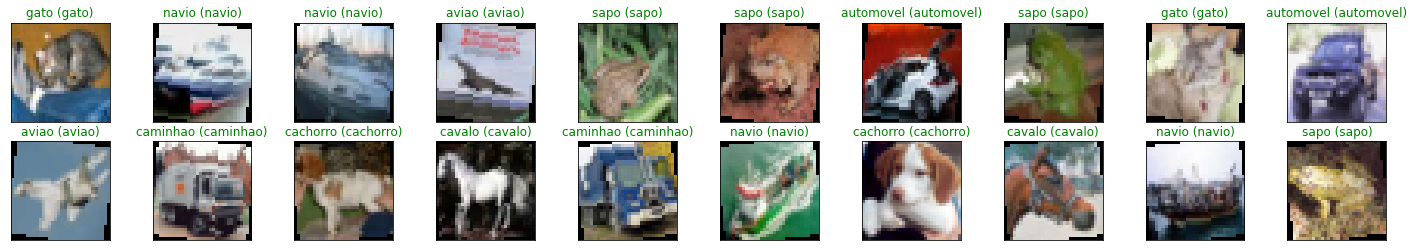

In [35]:
# obtendo um batch de amostras de teste
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# movendo as entradas para GPU
if train_on_gpu:
    images = images.cuda()

# obtendo as saidas
output = model(images)
# convertendo as probabilidades em classes
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotando as imagens do batch junto com a classe predita e real
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].to('cpu'))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))